# Repositorien auf Wikipedia

Wikipedia ist eine der weltweit am meisten genutzten Internetangebote und ein zentraler Informationsservice. Allein die englische Wikipedia zählt über 6 Millionen Einträge. Alle Wikipedias zusammen verzeichnen monatlich annähernd 2 Milliarden Zugriffe <a href="https://stats.wikimedia.org/#/all-wikipedia-projects/reading/unique-devices/normal|bar|2-year|(access-site)~mobile-site*desktop-site|monthly">(Link)</a>.

Allein durch die schiere Menge an Content und die damit einhergehende Popularität ist Wikipedia als eine gewichtige Akteurin im heutigen öffentlichen und auch wissenschaftlichen Informationsökosystem anzusehen. Forscher:innen benutzen selbstverständlich Wikipedia z.B. zum Nachschlagen und zur schnellen Recherche.

Der Einfluss auf die Forschung ist dabei zwar i.d.R. mittelbar oder aber verschleiert (vgl. etwa [Link](https://sciencesprings.wordpress.com/2018/02/08/from-sciencenews-wikipedia-has-become-a-science-reference-source-even-though-scientists-dont-cite-it/) bzw. [Link](https://www.sciencenews.org/blog/scicurious/wikipedia-science-reference-citations)).

Unabhängig von der wissenschaftlichen [Belastbarkeit](https://en.wikipedia.org/wiki/Reliability_of_Wikipedia) der Einträge im Einzelnen und der Akzeptanz in der Wissenschaftscommunity im Allgemeinen (vgl. etwa [Polk/Evers 2015](https://doi.org/10.1007/s11528-015-0858-6), [Selwyn/Gorard 2015](https://doi.org/10.1016/j.iheduc.2015.08.004) und [Teplitskiy et al. 2017](http://arxiv.org/abs/1506.07608)) bietet Wikipedia gerade für Fachinformationsdienstleister eine bedeutende Plattform zur Distribution von Fachinformation und zur Bewerbung der eigenen Services.

Im Folgenden soll ein Analyse zur Zahl der Verweise auf gängige Fach- und allgemeine Repositorien auf verschiedenen Sprachversionen von Wikipedia vorgestellt werden.

## Repositorien

In `REPOS` wurden die URL verschiedener relevanter Repositorien zusammengetragen. Die Auswahl ließe sich beliebig erweitern oder einschränken.

Die URL müssen ohne Protokoll (`http://` bzw. `https://`) angeben.

In [339]:
REPOS = {
    'Propylaeum': "archiv.ub.uni-heidelberg.de/propylaeumdok",
    'MenaDoc': "menadoc.bibliothek.uni-halle.de",
    #'MenaDoc DOI' :'dx.doi.org/10.25673',
    #'Share_It' : 'opendata.uni-halle.de',
    #'intR2' : 'intr2dok.vifa-recht.de',
    'core' : 'core.ac.uk',
    #'Refubium' : 'refubium.fu-berlin.de',
    'edoc HU' : 'edoc.hu-berlin.de',
    'BIB OPUS' : 'opus4.kobv.de',
    #'SLUB Qucosa' : 'slub.qucosa.de',
    #'bonndoc' : 'bonndoc.ulb.uni-bonn.de',
    #'Uni Tübingen' : 'publikationen.uni-tuebingen.de',
    'DASH Harvard' : 'dash.harvard.edu',
    'DSpace@MIT' : 'dspace.mit.edu',
    #'ORA Oxford' : 'ora.ox.ac.uk',
    'Zenodo' : 'zenodo.org/record',
    'Zenodo DOI' : 'doi.org/10.5281'
       }

In [262]:
# Import der benötigten Module

import requests
from bs4 import BeautifulSoup

import pandas as pd

# Zur Generierung des Zeitstempels
from datetime import datetime

In [305]:
# Definiere Funktion zum Abruf der Wikipedia-API.
# Es wird eine Liste von Dictionaries zurückgegeben.

"""
    get_exturlusage.py

    MediaWiki API Demos
    Demo of `Exturlusage` module: Enumerate pages that contain a given URL.

    MIT License
    
    angepasst durch Alexander Winkler
"""

S = requests.Session()

def get_links_from_wikis(code,repo_url):
    URL = f"https://{code}.wikipedia.org/w/api.php"

    PARAMS = {
        "action": "query",
        "format": "json",
        "list": "exturlusage",
        "euquery": repo_url,
        "eulimit" : 500,
        "meta" : "siteinfo"
    }

    R = S.get(url=URL, params=PARAMS)
    DATA = R.json()

    EXTURLS = DATA["query"]["exturlusage"]

    return_list = [{
        'repo' : repo_url,
        'titel': exturl["title"],
        'url' : exturl["url"],
        'code' : code,
        'pageID' : exturl["pageid"]} for exturl in EXTURLS]
    return return_list

## Wikipedia-Versionen

Erzeuge eine Liste der verschiedenen Wikipedia-Versionen auf Basis einer entsprechenden Liste auf `wikipedia_list_url`. Es wird eine Liste (`WIKIS`) von Dictionaries zurückgegeben.

In [300]:
wikipedia_list_url = "https://en.wikipedia.org/wiki/List_of_Wikipedias"

req = requests.get(wikipedia_list_url)
html = req.content
soup = BeautifulSoup(html, 'html.parser')
table = soup.findAll('table')[1]

WIKIS = []
rows = table.findAll('tr')
for row in rows[1:]:
    link = row.findAll('td')[2].find('a')
    code = link.text
    wiki_link = link['href']
    language = row.find('td').text
    WIKIS.append({
        'code' : code,
        'link' : wiki_link,
        'lang' : language
    })

In [336]:
# Abfrage der Wikipedia-Versionen (bis `cutoff` in der Liste,
# um nicht immer alle Versionen abfragen zu müssen). Cutoff-Wert
# entspricht also der Zahl von Wikipedia-Versionen.

cutoff = 5

OUTPUT_DICT = {}
for name,url in REPOS.items():
    output = []
    for wiki in WIKIS[:cutoff-1]:
        try:
            OUT = get_links_from_wikis(wiki['code'],url)
            output.append(OUT)
        except Exception as e:
            print(e)
            print(wiki['lang'])
    OUTPUT_DICT[name] = output

In [337]:
# Forme OUTPUT_DICT um, um besser plotten zu können.

PLOT_DICT = {}

for k in OUTPUT_DICT.keys():
    if not k in PLOT_DICT.keys():
        PLOT_DICT[k] = {}
    for elem in OUTPUT_DICT[k]:
        for e in elem:
            try:
                PLOT_DICT[k][e['code']] += 1
            except KeyError:
                PLOT_DICT[k][e['code']] = 1

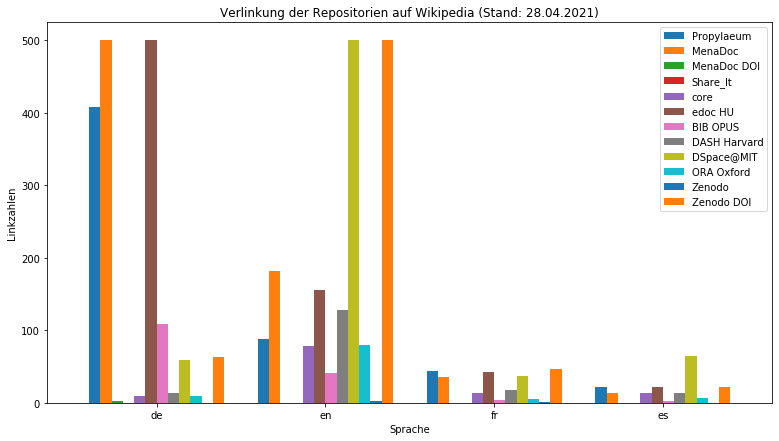

In [338]:
#https://stackoverflow.com/questions/56076590/plotting-multiple-bars-with-matplotlib-using-ax-bar

# Erzeuge Zeitstempel
date = datetime.today().strftime("%d.%m.%Y")

df = pd.DataFrame.from_dict(PLOT_DICT).sort_values(by='MenaDoc',ascending=False).head(7)

ax = df.plot.bar(rot=0,width=0.8,logy=False,align='center', figsize=(13,7))
titel = f"Verlinkung der Repositorien auf Wikipedia (Stand: {date})"
ax.set_title(titel)
ax.set_xlabel("Sprache")
ax.set_ylabel("Linkzahlen")
fig = ax.get_figure()
fig.savefig(f"repo_wiki_link_{date.replace('.','')}.png",dpi=250)

## Anmerkungen

Aus der Übersicht geht deutlich hervor, dass einige Repositorien (Menadoc, edoc HU und Propyläum) auf der deutschen Wikipedia recht stark vertreten sind, auf Ressourcen dieser Repositorien also oft verlinkt wird.
Die nationalen Repositorien in Deutschland bedienen dabei insbesondere die deutsche Community, strahlen jedoch offenbar auch in die englischsprachige Forschung aus. Zu klären wäre hier noch, ob sich die Links der englischen Wikipedia mit denen der deutschen Decken, der Rückgriff also durch Übersetzung o.ä. zu erklären ist, oder ob dieser eher unabhängig erfolgt ist.

Auffällig ist die generell deutlich größere Verbreitung von Links auf nationale Repositorien in Deutschland.

Eine wichtige Limitation der Analyse betrifft die in `REPOS` angegebenen URLs. In der Regel wurden keine DOI oder sonstige Resolver-Links berücksichtigt. Für Repositorien, die (wie z.B. [qucosa](https://tud.qucosa.de) der TU Dresden bzw. SLUB Dresden), für die persistente Zitation auf einen Linkresolver verweisen, kann es zu Verzerrungen kommen.

Die Graphik ist bei `y == 500` gekappt, weil die Wikipedia-API die Linkausgabe auf 500 beschränkt. Eine Lösung für dieses [Problem](https://stackoverflow.com/questions/67278483/continue-parameter-in-wikipedia-api-request) wurde noch nicht gefunden.

Alexander Winkler [(✉ E-Mail)](mailto:alexander.winkler@bibliothek.uni-halle.de), 28.4.2021


<div itemscope itemtype="https://schema.org/Person">
    <a itemprop="sameAs" content="https://orcid.org/0000-0002-9145-7238" href="https://orcid.org/0000-0002-9145-7238" target="orcid.widget" rel="me noopener noreferrer">
        <img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" alt="ORCID iD icon" align="left"/> https://orcid.org/0000-0002-9145-7238
    </a>
</div>



<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.